[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)](https://atmosphere.copernicus.eu)

<h1>Comparing TROPOMI NO2 columns with the CAMS regional air quality ensemble product </h1>

**Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/main?labpath=06-ak/notebook_3/no2_tropomi_cams_regional.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/blob/main/06-ak/notebook_3/no2_tropomi_cams_regional.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/blob/main/06-ak/notebook_3/no2_tropomi_cams_regional.ipynb)

In this tutorial you will compare TROPOMI NO2 tropospheric column observations with CAMS regional ensemble data. 


A detailed explanation on the TROPOMI-CAMS comparison approach can be found in the following paper <br>
Douros et al., 2023, <a href="https://doi.org/10.5194/gmd-16-509-2023">https://doi.org/10.5194/gmd-16-509-2023</a>


All TROPOMI operational products (including NO<sub>2</sub>) come with three documents:<br>
1. The Product Readme File (PRF): This provides an overview of code changes and versions and some high level recommendations for use.<br>
2. The Product User Manual (PUM): Describing the fields in the data file and data use.<br>
3. The Algorithm Theoretical Baseline Document (ATBD): Describing the retrieval algorithm in detail.

These documents are provided by Copernicus/ESA on the Sentinel-5P Document Library page:<br>
https://sentiwiki.copernicus.eu/web/s5p-products

The v2 NO<sub>2</sub> retrieval and validation are described in the following paper:<br>
Jos van Geffen et al.,
<i>Sentinel-5P TROPOMI NO2 retrieval: impact of version v2.2 improvements and comparisons with OMI and ground-based data</i><br>
<a href="https://doi.org/10.5194/amt-15-2037-2022">https://doi.org/10.5194/amt-15-2037-2022</a>

In this notebook we will focus on Europe, 
and will pick a day with a relatively low cloud cover over central-western Europe:  
26 July 2018. The same day was shown in the Douros paper.

For this tutorial we will use a more recent dataset, namely the TROPOMI NO<sub>2</sub> reprocessing based on processor version 2.4. <br>
This dataset is now available on the Copernicus Dataspace, and individual orbits can be downloaded here:<br>
<a href="https://dataspace.copernicus.eu">https://dataspace.copernicus.eu</a>

This tutorial is based on the following file, available from the dataspace:<br>
S5P_RPRO_L2__NO2____20180726T113922_20180726T132051_04059_03_020400_20221105T081652.nc


The NO2 retrieval files for individual orbits are large, about 600 Mb. <br>
For this tutorial we have prepared a file with a reduced volume. <br>
In particular:<br>
- We removed several fields from the file which are not needed for the use of the data.<br>
- We cropped the orbit keeping only data which overlaps the CAMS European domain (a lat-lon region covering Iceland down to Turkey).

the "reduced_eu" datafile we obtained has a size of 81 Mb.

As explained in Douros et al., there are several ways to compare model output with the TROPOMI data.<br>

1. Convert the three-dimensional model output to model subcolumns (unit mol/m<sup>2</sup>, as in TROPOMI). Then sum up all layers in the troposphere to obtain a modelled tropospheric column. This can be compared with the tropospheric column in the TROPOMI file.

2. Make use of the kernels in the retrieval. Multiply the model subcolumns with the averaging kernel values and then sum over the layers. The compare with the TROPOMI column in the L2 datafile.

3. Replace the a-priori that was used in the retrieval by the profiles from the CAMS ensemble, and recompute the TROPOMI retrieved tropospheric column.


<div> <img src="Inputs_NO2/Douros.png" width="400"> </div>

Comparison 1 (orange arrow in the figure, taken from Douros et al.) is sub-optimal because the relative (model-observation)/observation difference is depending on the a-priori which was used in the retrieval. This approach should be avoided.

Comparisons 2 and 3 are both optimal (green arrows in the figure). In both these cases the relative comparison no longer depends on the retrieval a-priori.

<h3>Limitations in using the CAMS regional ensemble data</h3>

The CAMS global fields have a resolution of about 0.4 degree, or 40 km. TROPOMI has a resolution of about 4.5 km at nadir (looking down), and about 6 km on average (all viewing angles). Therefore a single CAMS global gridcell corresponds about 40-80 measurements of TROPOMI. 

The comparisons with the CAMS regional ensemble is more interesting. This ensemble has a resolution of 0.1 degree, and a gridcell corresponds to about 4 satellite measurements. CAMS regional much better resolves the sources, like large and medium size cities, major industrial sites, power plants, major roads, airports and ship tracks. Therefore we will demonstrate how the CAMS regional air-quality ensemble can be compared with TROPOMI.

It is important to realise that the CAMS regional 3-dimensional output, as provided on the ADS, has limitations. As a result interpolation errors may be considerable (see also Douros et al., 2023):

1. The number of vertical levels in CAMS is limited to 8. The heights of the levels are 0 50 250 500 1000 2000 3000 5000 meter above the surface.
2. The NO$_2$ concentration is provided at half-levels by CAMS. A simple linear interpolation was used in the vertical to obtain concentration values at full-levels. But this may cause substantial differences compared to the original model data.
3. Only altitude data is provided. Below, the pressure of the levels was approximated using a constant lapse rate, with an assumed surface temperature and surface pressure.
4. The data is available only up to 5000 meters. For a fair comparison with TROPOMI, data up to the tropopause (around 10 km) would have been required. (See Douros, 2023)

A more accurate comparion would require other outputs from the CAMS regional forecasts and anaylses, including pressure levels, a larger number of levels and model concentrations up to the tropopause. 

The CAMS global output provides this information on a large number of vertical layers (137). Interpolation errors are smaller for these global comparisons.

## 1. Python packages and directories 

Import the needed python packages. <br>
Special is the "xesmf" package, which contains some powerful interpolation routines.

We will also load some utility routines. We keep this notebook short, and the hard work is done by the routines in "utils_no2". If you are interested in these details you are welcome to investigate these utility routines.

In [5]:
import os
import xarray as xr
from netCDF4 import Dataset
import numpy as np

import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import scipy.constants as sc

from utils_no2 import *

ModuleNotFoundError: No module named 'netCDF4'

Define the directories with the CAMS regional ensemble data, the TROPOMI NO2 data. <br>
For plotting we also included a shape file for Europe.

Optionally you can also generate output image files. 

In [15]:
path_s5p = './Inputs_NO2/tropomi_no2_eu/S5P_RPRO_L2__NO2____20180726T113922_20180726T132051_04059_03_020400_20221105T081652_reduced_eu.nc'
path_cams = './Inputs_NO2/cams_regional_20180726.nc'
shp_file = './Inputs_NO2/Europe_shp/Europe.shp'
# outputs = './Outputs_NO2/'

## 2. Extract TROPOMI data

Read data from the TROPOMI netCDF file.

In [20]:
ds_PRODUCT = xr.open_dataset(path_s5p, group='PRODUCT', cache=True)
ds_SUPPORT_INPUT = xr.open_dataset(path_s5p, group='PRODUCT/SUPPORT_DATA/INPUT_DATA', cache=True)
ds_GL = xr.open_dataset(path_s5p, group='PRODUCT/SUPPORT_DATA/GEOLOCATIONS', cache=True)
    
no2_tropomi = ds_PRODUCT['nitrogendioxide_tropospheric_column'][0,:,:] * (6.022141e+19/1e15) # Conversion to Pmolec/cm2

# get data dimensions
scanlines, ground_pixels = no2_tropomi.values.shape

# Get TROPOMI pixel centre lons and lats
lon_s5p = ds_PRODUCT['nitrogendioxide_tropospheric_column'][0,:,:].longitude.values
lat_s5p = ds_PRODUCT['nitrogendioxide_tropospheric_column'][0,:,:].latitude.values

qavalue = ds_PRODUCT["qa_value"][0,:,:].values

lon_b_s5p, lat_b_s5p = grid_bounds(scanlines, ground_pixels, ds_GL)

AK_trop = ds_PRODUCT['air_mass_factor_total'][0,:,:] / ds_PRODUCT['air_mass_factor_troposphere'][0,:,:] * ds_PRODUCT['averaging_kernel'][0,:,:]
AK_trop = AK_trop.transpose('layer','scanline','ground_pixel').astype('float32', order='C')

AK = ds_PRODUCT['averaging_kernel'][0,:,:]

sp_tropomi = ds_SUPPORT_INPUT['surface_pressure'][0,:,:].values

ds_PRODUCT



<xarray.Dataset>
Dimensions:                                               (time: 1,
                                                           scanline: 970,
                                                           ground_pixel: 450,
                                                           layer: 34,
                                                           corner: 4,
                                                           vertices: 2)
Coordinates:
  * corner                                                (corner) float64 0....
  * ground_pixel                                          (ground_pixel) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
  * layer                                                 (layer) float64 0.0...
    longitude                                             (time, scanline, ground_pixel) float32 ...
  * scanline                                              (scanline) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * vertices                                              (vertices) float64 ...
Data variables:
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    delta_time                                            (time, scanline) datetime64[ns] ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    time_utc                                              (time, scanline) object ...
    tm5_constant_a                                        (layer, vertices) float32 ...
    tm5_constant_b                                        (layer, vertices) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...

The "PRODUCT" folder of the TROPOMI retrieval file 
contains a large number of fields relevant for the retrieval, including inputs and intermediate results.

The "METADATA" folder contains the names, versions, creation dates of all inputs, providing full traceabilty.

If you are interested you are welcome to explore the TROPOMI dataset and plot several fields to get more insight in the retrieval approach and data product.

The PUM (Product Readme File) contains a table with the key fields needed for specific applications.

In our case, for comparing with 3D model output, we need:<br>
- The tropospheric column (and it's uncertainty)<br>
- The qa_value to filter the data and keep only relevant observations. We are interested in cloud-free observations, which corresponds to qa_values > 0.75.<br>
- The averaging kernel, a 34 level vector for each observation.<br>
- The total and tropospheric air-mass factor (AMF). These are needed to convert the total column averaging kernel into a tropospheric column averaging kernel. We will use only the levels in the troposphere, removing the stratosphere.<br>
- The longitude, latitude coordinates of the satellite observations, the layer information (the tm5 a and b constants and the surface pressure), and the index of the layer corresponding to the tropopause.


The TROPOMI retrieval is provided in mol / m<sup>2</sup>. <br>
Historically, column retrievals from instruments like OMI, GOME-2, are provided in molecules / cm<sup>2</sup>. <br>
A typical amount is 1e15 molecules / cm<sup>2</sup>, or "Pmolec/cm<sup>2</sup>".
The comparisons will be presented in this unit.

For column retrievals the averaging kernel becomes a vector (a profile). 
This profile is a measure of the sensitivity of the satellite observation to 
NO<sub>2</sub> at a given altitude. NO<sub>2</sub> is retrieved in the 400-500 nm spectral range, where Raileigh scattering is important.<br>
Each retrieval has its own kernel, depending on retrieval parameters like the surface reflectivity, cloud cover, geometry (solar zenith and satellite viewing angles). The image below shows three examples (note that the kernels were normalised to 1 in the stratosphere for this plot):

- (a) When the surface is dark the sensitivity close to the surface (and kernel value) is small.

- (b) When the surface is bright (e.g. sand, snow) the sensitivity close to the surface is large.

- (c) Clouds obscure the NO<sub>2</sub> close to the surface. The satellite has almost no sensitivity below the cloud, but is more sensitive just above the cloud.

<div> <img src="Inputs_NO2/no2_kernel_examples.png" width="400"> </div>



The observation operator <b>H</b> for the total column quantity has the form:

<div> <img src="Inputs_NO2/Hx_Rodgers.png" width="220"> </div>

Here the bold face characters (averaging kernel, model profile and a-priori profile) are vectors. The column quantities (the a-priori column) is indicated in italic. The formula involves a vector dot product. Note that we assume that the model profile <b>x</b> was already interpolated to the satellite location and time, and to the same vertical grid.

For the weak absorber total column DOAS retrieval (e.g. TROPOMI NO2) the formula simplifies further. For this retrieval:

<div> <img src="Inputs_NO2/xa_Axa.png" width="150"> </div>

and the observation operator is simply the averaging kernel

<div> <img src="Inputs_NO2/Hx_Ax.png" width="100"> </div>

The retrieved column (a single number) is compared with the dot product of the kernel vector and the vector of modelled partial columns for all the vertical layers.

Since the a-priori profile is not needed to compare the retrieval with models the a-priori is not provided in the NO2 data product. <br>
Adding the a-priori profile would increase the size of the L2 datafile considerably.

Now first compute the full and half level fields for the TROPOMI vertical grid. 

TROPOMI uses the global TM5 model to generate a-prioir profiles and estimates of the stratospheric part of the total column. <br>
TM5 is driven by ECMWF IFS meteorology, and the vertical grid of TM5 is a subset of the IFS layers (from 137 to 34).

In [17]:
fl_fields, hl_fields, tm5_levels = pressure_alts_tm5(scanlines, ground_pixels, ds_PRODUCT['tm5_constant_a'], ds_PRODUCT['tm5_constant_b'], sp_tropomi, ds_PRODUCT['averaging_kernel'][0,:,:,:])
hl_fields = hl_fields.transpose('layer','scanline','ground_pixel').astype('float32', order='C')
fl_fields = fl_fields.transpose('layer','scanline','ground_pixel').astype('float32', order='C')
fl_fields['TM5_tropopause'] = (('scanline', 'ground_pixel'),ds_PRODUCT['tm5_tropopause_layer_index'].values.squeeze())

## 3. Extract CAMS regional data

We perform a simple time collocation by picking the CAMS field at 12:00 utc, close to overpass time.

In [21]:
cams_reg = xr.open_dataset(path_cams)

lat_cams = cams_reg.lat.values
lon_cams = cams_reg.lon.values
alt_cams = cams_reg.lev.values           # Units: meters
no2_cams = cams_reg.no2.values[12,:,:,:] # Units: ug/m3
no2_cams = no2_cams * sc.Avogadro / (1e6 * 46.0055) # Change units to molecule/m3 

# Extract the horizontal spacing in lat and lon
dlon_cams = np.absolute(lon_cams[1] - lon_cams[0])
dlat_cams = np.absolute(lat_cams[1] - lat_cams[0])

# Define the bounds of the grid corners
lonmin_cams = np.min(lon_cams) - 0.5 * dlon_cams
lonmax_cams = np.max(lon_cams) + 0.5 * dlon_cams
latmin_cams = np.min(lat_cams) - 0.5 * dlat_cams
latmax_cams = np.max(lat_cams) + 0.5 * dlat_cams

cams_reg


<xarray.Dataset>
Dimensions:  (time: 24, lev: 8, lon: 701, lat: 421)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-26 ... 2018-07-26T23:00:00
  * lev      (lev) int64 0 50 250 500 1000 2000 3000 5000
  * lon      (lon) float64 -25.0 -24.9 -24.8 -24.7 -24.6 ... 44.7 44.8 44.9 45.0
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 71.6 71.7 71.8 71.9 72.0
Data variables:
    no2      (time, lev, lat, lon) float64 0.07022 0.06674 ... 0.05592 0.05435

In [22]:
cams_reg.lev

<xarray.DataArray 'lev' (lev: 8)>
array([   0,   50,  250,  500, 1000, 2000, 3000, 5000])
Coordinates:
  * lev      (lev) int64 0 50 250 500 1000 2000 3000 5000

## 4. Regrid CAMS regional data onto the TROPOMI grid

The xesmf package is used to perform the horizontal interpolation: <br>
this involves a conservative regridding from the CAMS grid onto the TROPOMI footprints.

In [23]:
regrid_no2 = xesmf_conservative_cams_s5p(scanlines, ground_pixels, no2_cams, ds_GL, lonmin_cams, lonmax_cams, latmin_cams, latmax_cams, dlon_cams, dlat_cams, lon_b_s5p, lat_b_s5p, lon_s5p, lat_s5p)

## 5. Estimate full and half levels pressures, altitudes and NO2 concentrations for CAMS

A simple aproximation is used for the vertical grid. Assumed surface presure and constant lapse rate to derive pressure at the full and half levels. A simple linear interpolation is applied for NO<sub>2</sub> at the center of the grid.

In [7]:
pres_fl_cams, z_fl_cams, pres_hl_cams, z_hl_cams, no2_cams_fl = CAMS_reg_levels(regrid_no2, alt_cams, sp_tropomi)

## 6. Compute the subcolumn and column values, and update TROPOMI apriori

Find only pixels with valid model data (this saves time for the loops later):

In [8]:
valindex = np.argwhere(~np.isnan(no2_cams_fl[0,:,:])) 

Estimate total columns and layer subcolumns, with and without multiplying with the AK:

In [9]:
no2_col, no2_subcol = no2_column_cams_simple(no2_cams_fl, z_hl_cams)
no2_col_aks, no2_subcol_aks = no2_column_cams_interp(no2_cams_fl, z_hl_cams, pres_fl_cams, AK_trop, fl_fields, valindex)

/Users/eskes/Documents/werk/prog/tropomi/ESA_school_py_notebook_AK/06_ak/utils_no2.py:169: RuntimeWarning: invalid value encountered in scalar divide
  m = (AK_trop.values[index_p1,y,z] - AK_trop.values[index_p2,y,z]) / (tm5_press_levels[index_p1,y,z] - tm5_press_levels[index_p2,y,z])


(At a few points the inputs are not defined, and these create a warning.)

Now the retrieved TROPOMI tropospheric column is updated by replacing the TROPOMI apriori by the CAMS regional profile. <br> 
As explained in the PUM, this calculation uses the two summations that were computed in the previous line, and becomes a simple expression: 

In [10]:
column_ratio_cams= no2_col / no2_col_aks
no2_tropomi_cams = column_ratio_cams * no2_tropomi

/var/folders/_0/fzcnyx3n1xvcjgdstb5zhcmh0000gn/T/ipykernel_83141/1828052817.py:1: RuntimeWarning: divide by zero encountered in divide
  column_ratio_cams= no2_col / no2_col_aks


## 7. Filter all the datasets using observations with a qa_value larger than 0.75

As mentioned before, we will only compare cloud-free pixels and pixels with a small cloud fraction.

In [11]:
no2_col_75 = np.where(qavalue<0.75, np.nan, no2_col)
no2_col_aks_75 = np.where(np.isnan(no2_col_75), np.nan, no2_col_aks)
no2_tropomi_75 = np.where(np.isnan(no2_col_75), np.nan, no2_tropomi)
no2_tropomi_cams_75 = np.where(np.isnan(no2_col_75), np.nan, no2_tropomi_cams)

## 7. Plotting the data

A four-panel plot is created, showing the two retrieval versions and the two model versions after applying the observation operator.

Text(0.5, 0.98, 'NO$_2$ VCD - 2018/07/26')

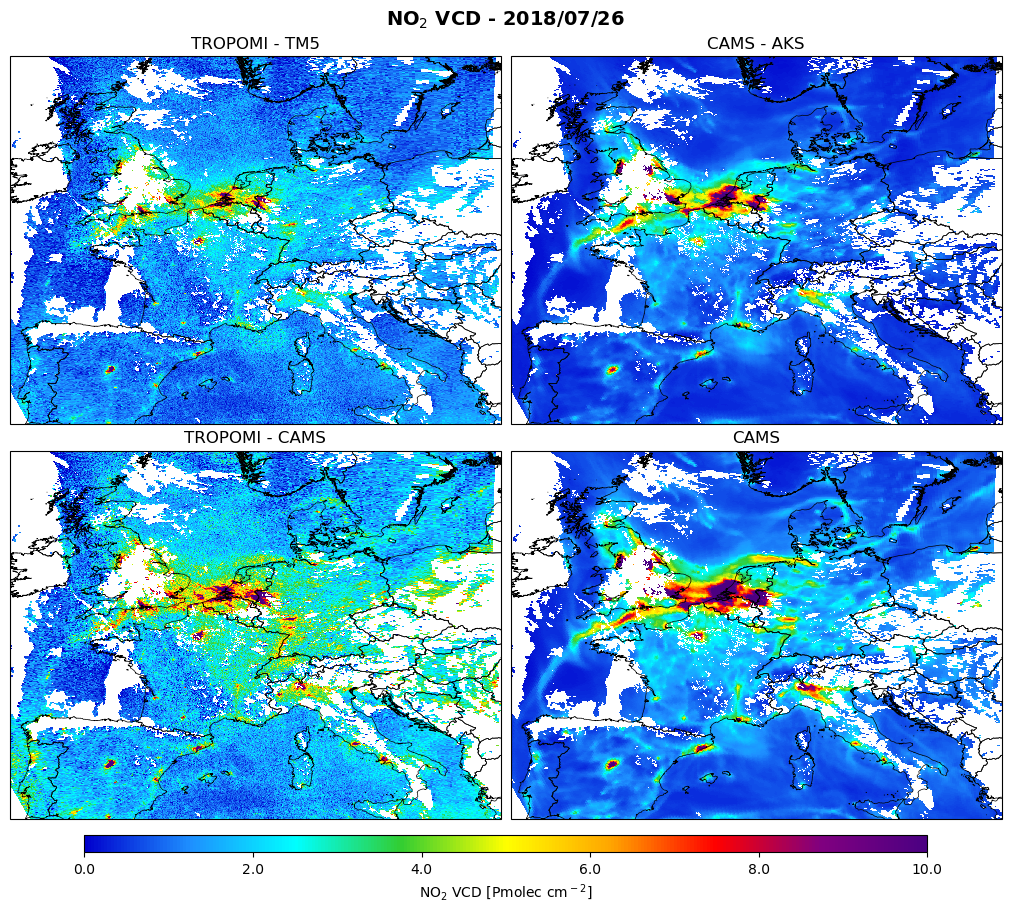

In [13]:
colors = ["mediumblue", "dodgerblue", "cyan", "limegreen", "yellow", "orange", "red", "purple", "indigo"]
colormap = LinearSegmentedColormap.from_list("mycmap", colors)

fig, axs = plt.subplots(2, 2, figsize=(10,9),subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

shape_feature = ShapelyFeature(Reader(shp_file).geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black')
axs[0,0].add_feature(shape_feature, linewidth=0.5)
axs[0,1].add_feature(shape_feature, linewidth=0.5)
axs[1,0].add_feature(shape_feature, linewidth=0.5)
axs[1,1].add_feature(shape_feature, linewidth=0.5)

c0=axs[0,0].pcolormesh(lon_s5p, lat_s5p, no2_tropomi_75, vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap=colormap)
c0=axs[0,1].pcolormesh(lon_s5p, lat_s5p, no2_col_aks_75, vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap=colormap)
c0=axs[1,0].pcolormesh(lon_s5p, lat_s5p, no2_tropomi_cams_75, vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap=colormap)
c0=axs[1,1].pcolormesh(lon_s5p, lat_s5p, no2_col_75, vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap=colormap)

cbar0=fig.colorbar(c0, ax=axs[:,:], location='bottom', shrink=0.85, aspect=50, pad=0.02,fraction=0.1, format = '%.1f')
cbar0.set_label('NO$_2$ VCD [Pmolec cm$^-$$^2$]')

axs[0,0].set_ylim(37,61)
axs[0,0].set_xlim(-10,22)
axs[0,1].set_ylim(37,61)
axs[0,1].set_xlim(-10,22)
axs[1,0].set_ylim(37,61)
axs[1,0].set_xlim(-10,22)
axs[1,1].set_ylim(37,61)
axs[1,1].set_xlim(-10,22)

axs[0,0].set_title('TROPOMI - TM5')
axs[0,1].set_title('CAMS - AKS')
axs[1,0].set_title('TROPOMI - CAMS')
axs[1,1].set_title('CAMS')

plt.suptitle('NO$_2$ VCD - 2018/07/26', fontsize=14, fontweight='bold')

# saveplot = outputs + 'TROPOMI_vs_CAMS_NO2_20180726.png'
# plt.savefig(saveplot, dpi = 300, bbox_inches='tight')

The figure shows the comparison for 26 July 2018:<br>
- top-left: The TROPOMI tropospheric NO2 column retrieval <br>
- bottom-left: The TROPOMI NO2 retrieval but with CAMS as a-priori profile <br>
- top-right: The CAMS NO2 column with averaging kernel applied <br>
- bottom-right: The CAMS vertical column

The white areas correspond to cloud cover. The model has exactly the same gaps due to clouds, because the model is interpolated to the TROPOMI observations and also filtered with the same qa_value > 0.75.


First note the high degree of consistency between the modelled and observed NO2 fields. <br>
All major cities show up as emission hotspots, but looking in more detail we can also identify signals from industry, power generation, roads (for instance the "route du soleil" highway in the south-east of France), airports.

The two good ways of comparing are the top-left with top-right, or bottom-left with bottom-right. <br>
The <i>relative</i> comparison is the same for these two.

The suboptimal way is comparing top-left with bottom-right. It is depending on the retrieval a-priori. The difference (model-TROPOMI)/TROPOMI is higher in this case.

As explained in the paper by Douros the coarse 1 degree global scale a-priori does not resolve the profiles expected over the emission hotspots. As a result of replacing the a-priori with CAMS, the NO<sub>2</sub> in emission regions has increased substantially. 

Background values are lower in CAMS. This may be attributed to the free troposphere. The retrieval predicts higher free tropospheric concentrations, and CAMS values above 5km are missing.